# Implementing an RNN for character level language modelling in TensorFlow.

In the model that we will build now, the input is a text document, and our goal is to develop a model that can generate new text similar to the input document.

We will use full text book as our input.

In character level language modelling, the input is broken down into a sequence of characters that are fed into our network one character at a time. The network will process each new character in conjunction with the memory of the previously seen characters to predict the next character.

Input data: To get the input data, visit the Project Gutenberg website at https://www.gutenberg.org, which will provide thousand of free ebooks.

In [1]:
from IPython.display import Image
import numpy as np
import pandas as pd

# Example Application

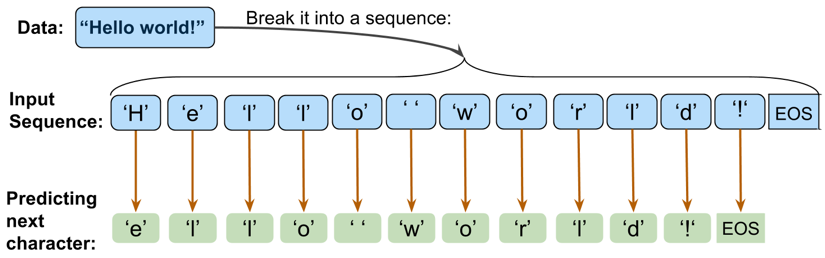

In [2]:
Image(filename='images/Unknown.png', width=600)

# Preparing the data

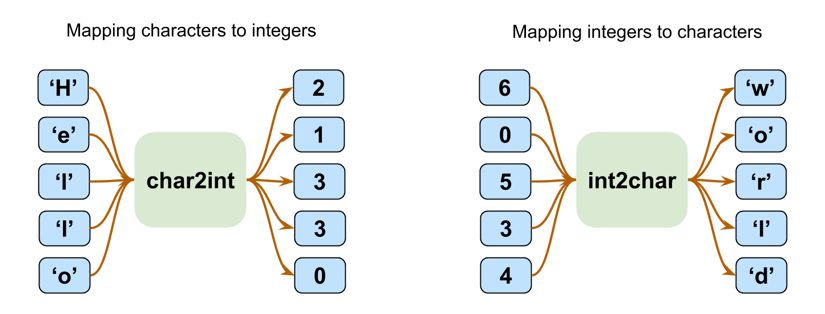

In [5]:
Image(filename='images/Unknown-2.png', width=600)

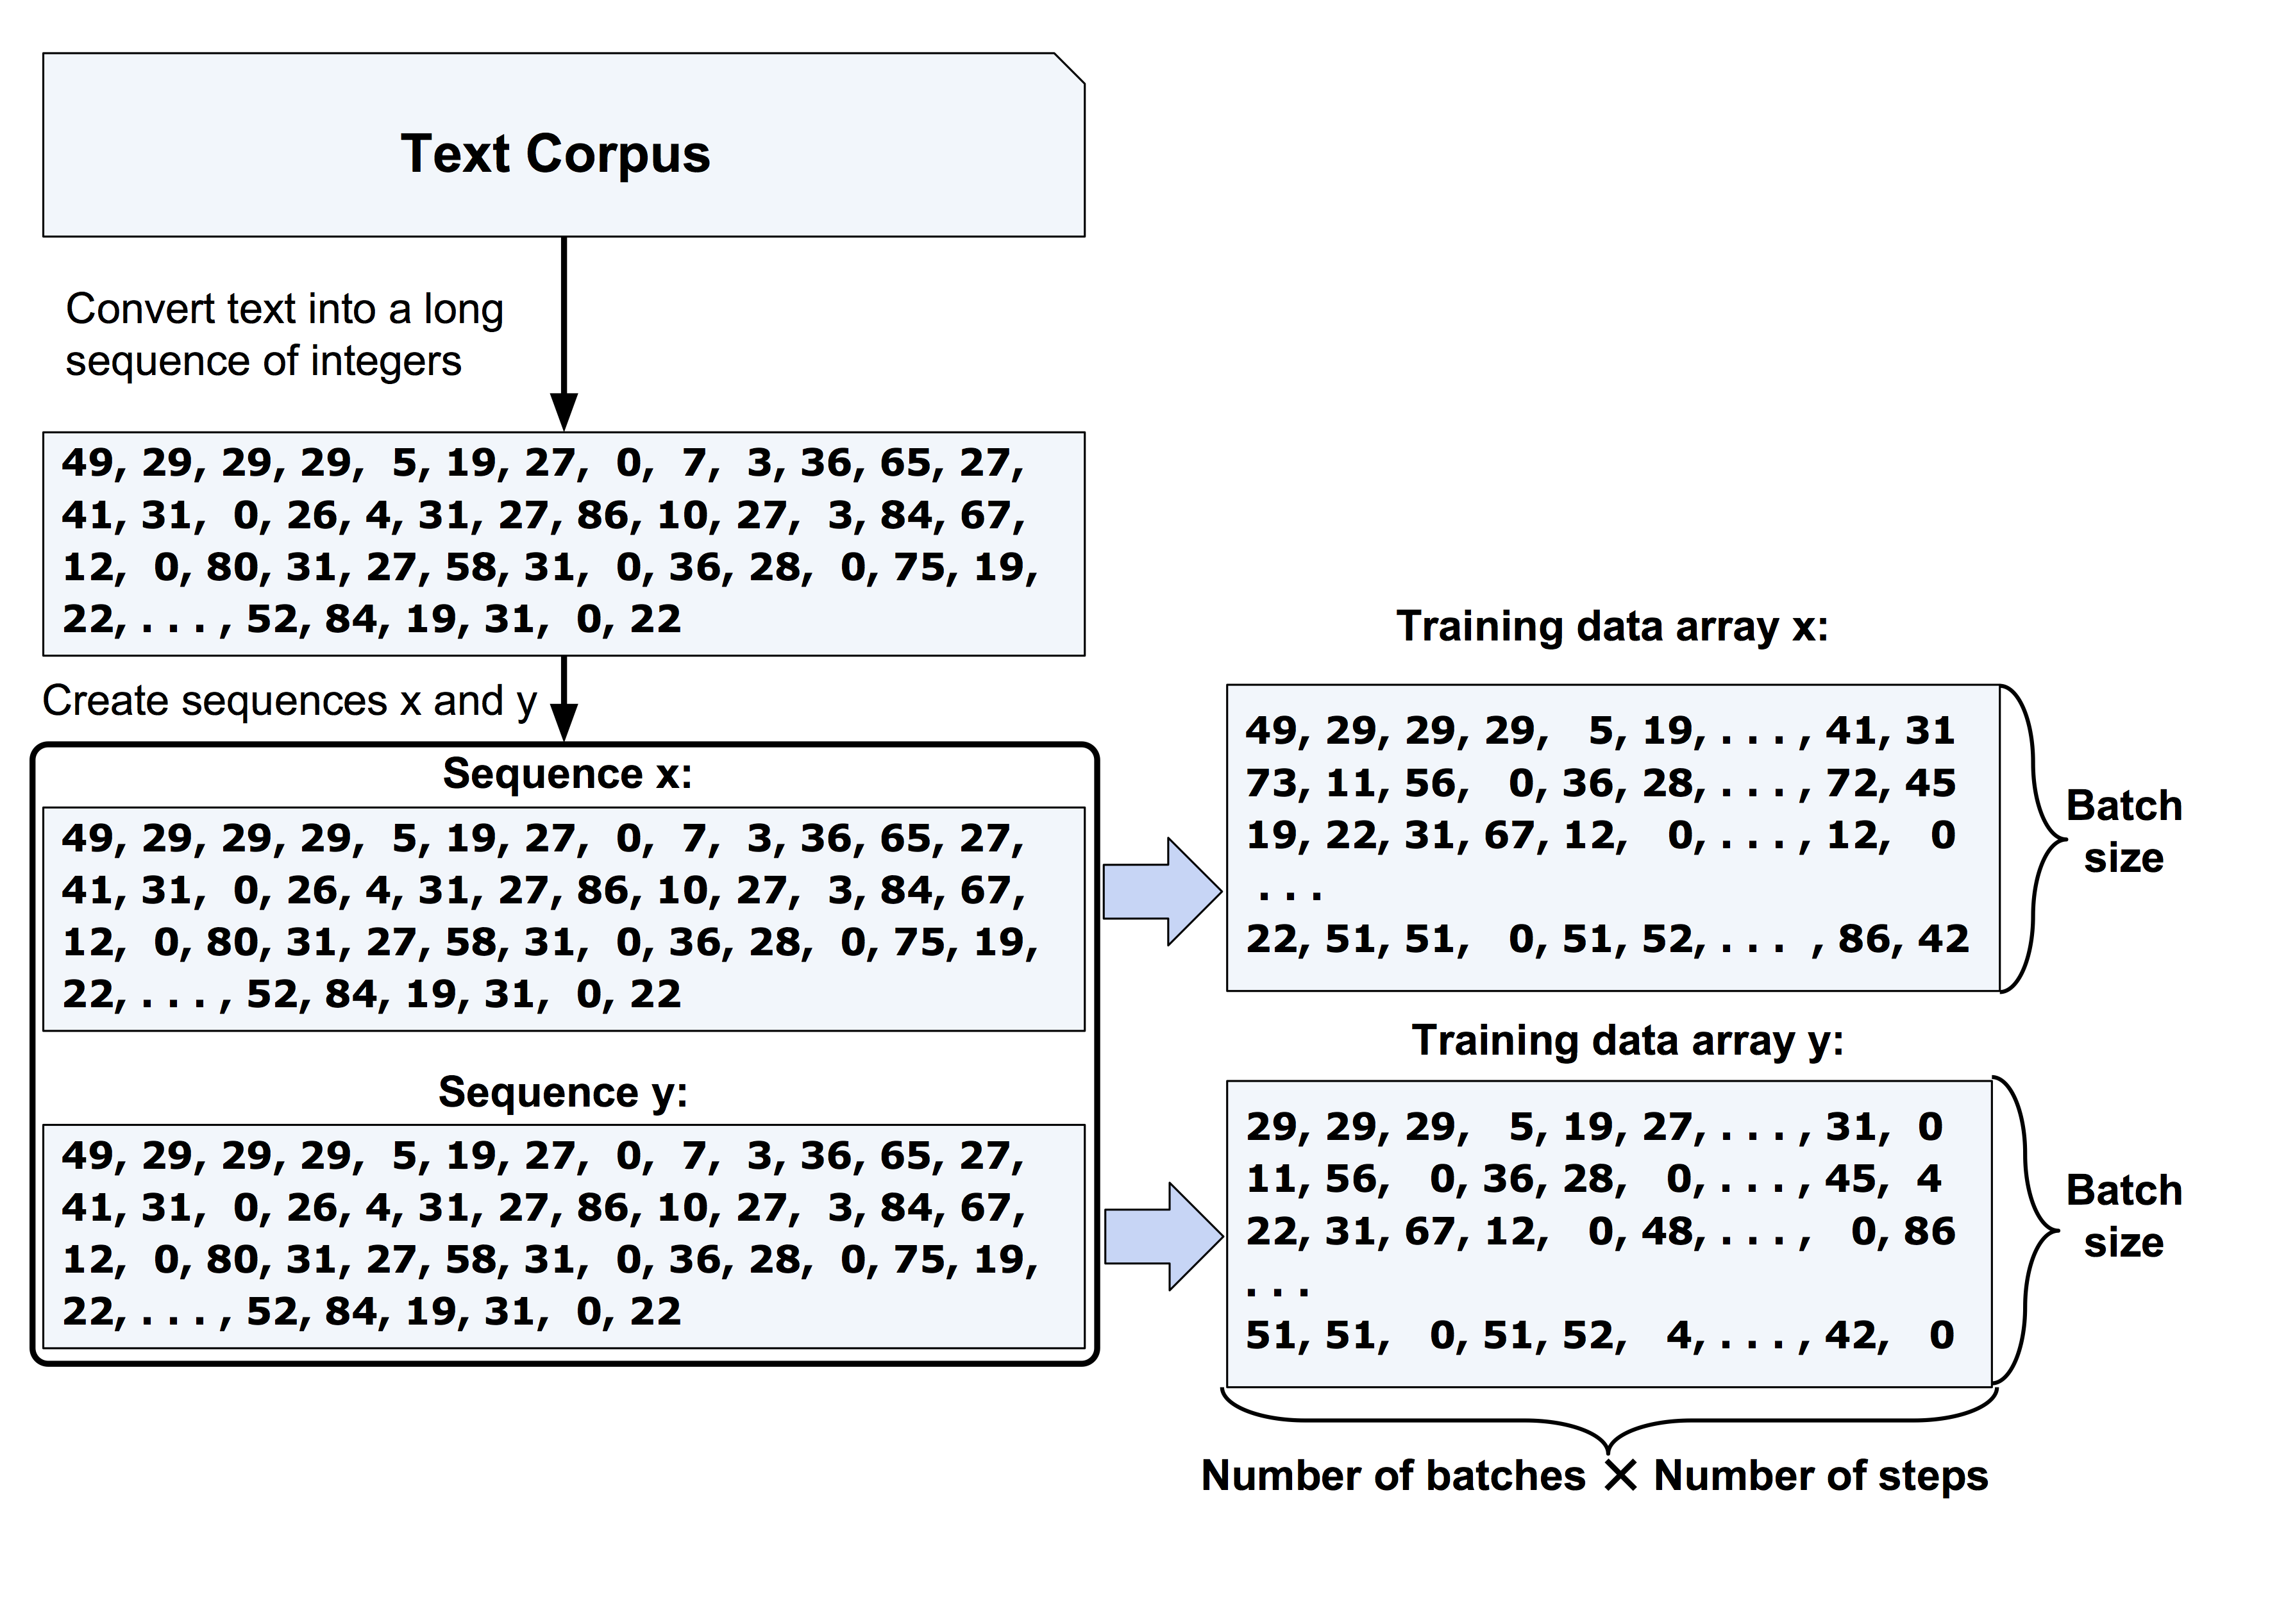

In [6]:
Image(filename='images/Unknown-3.png', width=600)

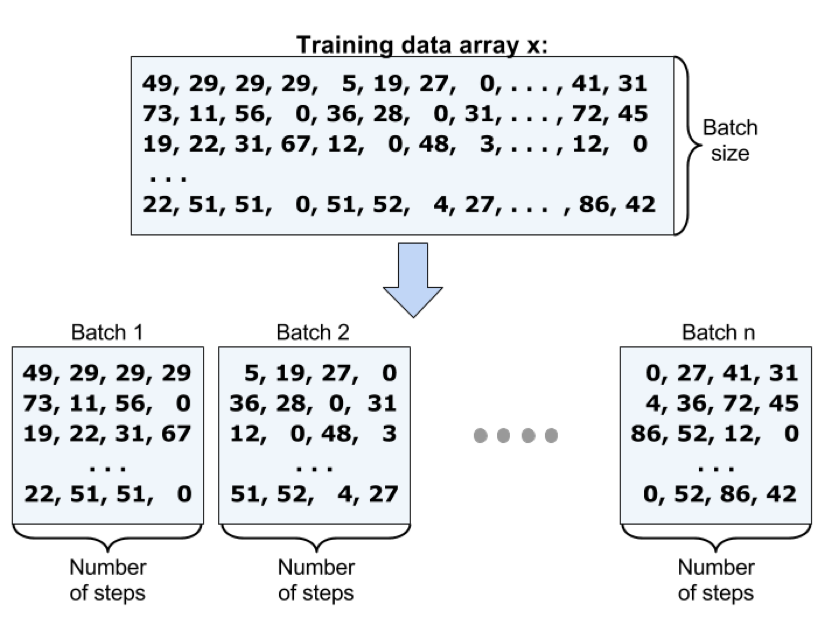

In [7]:
Image(filename='images/Unknown-4.png', width=600)

In [8]:
import numpy as np


## Reading and processing text
with open('pg2265.txt', 'r', encoding='utf-8') as f: 
    text=f.read()

text = text[15858:]
chars = set(text)
char2int = {ch:i for i,ch in enumerate(chars)}
int2char = dict(enumerate(chars))
text_ints = np.array([char2int[ch] for ch in text], 
                     dtype=np.int32)

In [9]:
text_ints

array([ 7, 23, 26, ..., 56,  4,  7], dtype=int32)

In [10]:
def reshape_data(sequence, batch_size, num_steps):
    tot_batch_length = batch_size * num_steps
    num_batches = int(len(sequence) / tot_batch_length)
    if num_batches*tot_batch_length + 1 > len(sequence):
        num_batches = num_batches - 1
    ## Truncate the sequence at the end to get rid of 
    ## remaining charcaters that do not make a full batch
    x = sequence[0 : num_batches*tot_batch_length]
    y = sequence[1 : num_batches*tot_batch_length + 1]
    ## Split x & y into a list batches of sequences: 
    x_batch_splits = np.split(x, batch_size)
    y_batch_splits = np.split(y, batch_size)
    ## Stack the batches together
    ## batch_size x tot_batch_length
    x = np.stack(x_batch_splits)
    y = np.stack(y_batch_splits)
    
    return x, y

## Testing:
train_x, train_y = reshape_data(text_ints, 64, 10)
print(train_x.shape)
print(train_x[0, :10])
print(train_y[0, :10])
print(''.join(int2char[i] for i in train_x[0, :50]))

(64, 2540)
[ 7 23 26 56 45 23 13 53 34 56]
[23 26 56 45 23 13 53 34 56  0]

The Tragedie of Hamlet

Actus Primus. Scoena Prim


In [11]:
np.random.seed(123)

def create_batch_generator(data_x, data_y, num_steps):
    batch_size, tot_batch_length = data_x.shape    
    num_batches = int(tot_batch_length/num_steps)
    for b in range(num_batches):
        yield (data_x[:, b*num_steps: (b+1)*num_steps], 
               data_y[:, b*num_steps: (b+1)*num_steps])
        
bgen = create_batch_generator(train_x[:,:100], train_y[:,:100], 15)
for b in bgen:
    print(b[0].shape, b[1].shape, end='  ')
    print(''.join(int2char[i] for i in b[0][0,:]).replace('\n', '*'), '    ',
          ''.join(int2char[i] for i in b[1][0,:]).replace('\n', '*'))

(64, 15) (64, 15)  *The Tragedie o      The Tragedie of
(64, 15) (64, 15)  f Hamlet**Actus       Hamlet**Actus 
(64, 15) (64, 15)   Primus. Scoena      Primus. Scoena 
(64, 15) (64, 15)   Prima.**Enter       Prima.**Enter B
(64, 15) (64, 15)  Barnardo and Fr      arnardo and Fra
(64, 15) (64, 15)  ancisco two Cen      ncisco two Cent


# Building the character-level RNN model

In [12]:
import tensorflow as tf
import os

class CharRNN(object):
    def __init__(self, num_classes, batch_size=64, 
                 num_steps=100, lstm_size=128, 
                 num_layers=1, learning_rate=0.001, 
                 keep_prob=0.5, grad_clip=5, 
                 sampling=False):
        self.num_classes = num_classes
        self.batch_size = batch_size
        self.num_steps = num_steps
        self.lstm_size = lstm_size
        self.num_layers = num_layers
        self.learning_rate = learning_rate
        self.keep_prob = keep_prob
        self.grad_clip = grad_clip
        
        self.g = tf.Graph()
        with self.g.as_default():
            tf.set_random_seed(123)

            self.build(sampling=sampling)
            self.saver = tf.train.Saver()
            self.init_op = tf.global_variables_initializer()
            
    def build(self, sampling):
        if sampling == True:
            batch_size, num_steps = 1, 1
        else:
            batch_size = self.batch_size
            num_steps = self.num_steps

        tf_x = tf.placeholder(tf.int32, 
                              shape=[batch_size, num_steps], 
                              name='tf_x')
        tf_y = tf.placeholder(tf.int32, 
                              shape=[batch_size, num_steps], 
                              name='tf_y')
        tf_keepprob = tf.placeholder(tf.float32, 
                              name='tf_keepprob')

        # One-hot encoding:
        x_onehot = tf.one_hot(tf_x, depth=self.num_classes)
        y_onehot = tf.one_hot(tf_y, depth=self.num_classes)

        ### Build the multi-layer RNN cells
        cells = tf.contrib.rnn.MultiRNNCell(
            [tf.contrib.rnn.DropoutWrapper(
                tf.contrib.rnn.BasicLSTMCell(self.lstm_size), 
                output_keep_prob=tf_keepprob) 
            for _ in range(self.num_layers)])
        
        ## Define the initial state
        self.initial_state = cells.zero_state(
                    batch_size, tf.float32)

        ## Run each sequence step through the RNN 
        lstm_outputs, self.final_state = tf.nn.dynamic_rnn(
                    cells, x_onehot, 
                    initial_state=self.initial_state)
        
        print('  << lstm_outputs  >>', lstm_outputs)

        seq_output_reshaped = tf.reshape(
                    lstm_outputs, 
                    shape=[-1, self.lstm_size],
                    name='seq_output_reshaped')

        logits = tf.layers.dense(
                    inputs=seq_output_reshaped, 
                    units=self.num_classes,
                    activation=None,
                    name='logits')

        proba = tf.nn.softmax(
                    logits, 
                    name='probabilities')
        print(proba)

        y_reshaped = tf.reshape(
                    y_onehot, 
                    shape=[-1, self.num_classes],
                    name='y_reshaped')
        cost = tf.reduce_mean(
                    tf.nn.softmax_cross_entropy_with_logits(
                        logits=logits, 
                        labels=y_reshaped),
                    name='cost')

        # Gradient clipping to avoid "exploding gradients"
        tvars = tf.trainable_variables()
        grads, _ = tf.clip_by_global_norm(
                    tf.gradients(cost, tvars), 
                    self.grad_clip)
        optimizer = tf.train.AdamOptimizer(self.learning_rate)
        train_op = optimizer.apply_gradients(
                    zip(grads, tvars),
                    name='train_op')
        
    def train(self, train_x, train_y, 
              num_epochs, ckpt_dir='./model/'):
        ## Create the checkpoint directory
        ## if does not exists
        if not os.path.exists(ckpt_dir):
            os.mkdir(ckpt_dir)
            
        with tf.Session(graph=self.g) as sess:
            sess.run(self.init_op)

            n_batches = int(train_x.shape[1]/self.num_steps)
            iterations = n_batches * num_epochs
            for epoch in range(num_epochs):

                # Train network
                new_state = sess.run(self.initial_state)
                loss = 0
                ## Minibatch generator:
                bgen = create_batch_generator(
                        train_x, train_y, self.num_steps)
                for b, (batch_x, batch_y) in enumerate(bgen, 1):
                    iteration = epoch*n_batches + b
                    
                    feed = {'tf_x:0': batch_x,
                            'tf_y:0': batch_y,
                            'tf_keepprob:0': self.keep_prob,
                            self.initial_state : new_state}
                    batch_cost, _, new_state = sess.run(
                            ['cost:0', 'train_op', 
                                self.final_state],
                            feed_dict=feed)
                    if iteration % 10 == 0:
                        print('Epoch %d/%d Iteration %d'
                              '| Training loss: %.4f' % (
                              epoch + 1, num_epochs, 
                              iteration, batch_cost))

                ## Save the trained model    
                self.saver.save(
                        sess, os.path.join(
                            ckpt_dir, 'language_modeling.ckpt'))
                              
                              
                
    def sample(self, output_length, 
               ckpt_dir, starter_seq="The "):
        observed_seq = [ch for ch in starter_seq]        
        with tf.Session(graph=self.g) as sess:
            self.saver.restore(
                sess, 
                tf.train.latest_checkpoint(ckpt_dir))
            ## 1: run the model using the starter sequence
            new_state = sess.run(self.initial_state)
            for ch in starter_seq:
                x = np.zeros((1, 1))
                x[0,0] = char2int[ch]
                feed = {'tf_x:0': x,
                        'tf_keepprob:0': 1.0,
                        self.initial_state: new_state}
                proba, new_state = sess.run(
                        ['probabilities:0', self.final_state], 
                        feed_dict=feed)

            ch_id = get_top_char(proba, len(chars))
            observed_seq.append(int2char[ch_id])
            
            ## 2: run the model using the updated observed_seq
            for i in range(output_length):
                x[0,0] = ch_id
                feed = {'tf_x:0': x,
                        'tf_keepprob:0': 1.0,
                        self.initial_state: new_state}
                proba, new_state = sess.run(
                        ['probabilities:0', self.final_state], 
                        feed_dict=feed)

                ch_id = get_top_char(proba, len(chars))
                observed_seq.append(int2char[ch_id])

        return ''.join(observed_seq)

In [13]:
def get_top_char(probas, char_size, top_n=5):
    p = np.squeeze(probas)
    p[np.argsort(p)[:-top_n]] = 0.0
    p = p / np.sum(p)
    ch_id = np.random.choice(char_size, 1, p=p)[0]
    return ch_id

In [14]:
batch_size = 64
num_steps = 100 
train_x, train_y = reshape_data(text_ints, 
                                batch_size, 
                                num_steps)

rnn = CharRNN(num_classes=len(chars), batch_size=batch_size)
rnn.train(train_x, train_y, 
          num_epochs=100,
          ckpt_dir='./model-100/')

  << lstm_outputs  >> Tensor("rnn/transpose:0", shape=(64, 100, 128), dtype=float32)
Tensor("probabilities:0", shape=(6400, 65), dtype=float32)
Epoch 1/100 Iteration 10| Training loss: 3.6115
Epoch 1/100 Iteration 20| Training loss: 3.3621
Epoch 2/100 Iteration 30| Training loss: 3.2861
Epoch 2/100 Iteration 40| Training loss: 3.2234
Epoch 2/100 Iteration 50| Training loss: 3.2356
Epoch 3/100 Iteration 60| Training loss: 3.2126
Epoch 3/100 Iteration 70| Training loss: 3.1940
Epoch 4/100 Iteration 80| Training loss: 3.1748
Epoch 4/100 Iteration 90| Training loss: 3.1515
Epoch 4/100 Iteration 100| Training loss: 3.1515
Epoch 5/100 Iteration 110| Training loss: 3.1292
Epoch 5/100 Iteration 120| Training loss: 3.1031
Epoch 6/100 Iteration 130| Training loss: 3.0665
Epoch 6/100 Iteration 140| Training loss: 3.0400
Epoch 6/100 Iteration 150| Training loss: 3.0029
Epoch 7/100 Iteration 160| Training loss: 2.9670
Epoch 7/100 Iteration 170| Training loss: 2.9212
Epoch 8/100 Iteration 180| Train

Epoch 65/100 Iteration 1620| Training loss: 2.0049
Epoch 66/100 Iteration 1630| Training loss: 1.9896
Epoch 66/100 Iteration 1640| Training loss: 2.0275
Epoch 66/100 Iteration 1650| Training loss: 1.9646
Epoch 67/100 Iteration 1660| Training loss: 2.0012
Epoch 67/100 Iteration 1670| Training loss: 1.9829
Epoch 68/100 Iteration 1680| Training loss: 1.9808
Epoch 68/100 Iteration 1690| Training loss: 2.0079
Epoch 68/100 Iteration 1700| Training loss: 1.9543
Epoch 69/100 Iteration 1710| Training loss: 1.9937
Epoch 69/100 Iteration 1720| Training loss: 1.9705
Epoch 70/100 Iteration 1730| Training loss: 1.9829
Epoch 70/100 Iteration 1740| Training loss: 2.0081
Epoch 70/100 Iteration 1750| Training loss: 1.9452
Epoch 71/100 Iteration 1760| Training loss: 1.9888
Epoch 71/100 Iteration 1770| Training loss: 1.9749
Epoch 72/100 Iteration 1780| Training loss: 1.9722
Epoch 72/100 Iteration 1790| Training loss: 1.9956
Epoch 72/100 Iteration 1800| Training loss: 1.9309
Epoch 73/100 Iteration 1810| Tr

In [15]:
np.random.seed(123)
rnn = CharRNN(len(chars), sampling=True)

print(rnn.sample(ckpt_dir='./model-100/', 
                 output_length=500))

  << lstm_outputs  >> Tensor("rnn/transpose:0", shape=(1, 1, 128), dtype=float32)
Tensor("probabilities:0", shape=(1, 65), dtype=float32)
INFO:tensorflow:Restoring parameters from ./model-100/language_modeling.ckpt
The that sithall weart and therare

   Ham. The areeses of healt so prowand, ar that thene mare:
And shat what soull a matries ane to the Satres

   Qu. Whore me then your mande our well thor in there
That tit with thou wand of is that sond be weell be as of
 t Hamlit,
I wolld the Sand are, and himenes mers it the wele,
Why cam to bee it to hinges thou therest then mest,
And thou wante hearst if the paritise ald and mare tingion,
That him the my buthand ours of teare

   Han. How and mare an hyo of h


In the resulting output, some english words are mostly preserved. It's also important to note that this is from old english text; therefore, some words in the original text may be unfamiliar. To get a better result, we would need to train the model for higher number of epochs.

In [16]:
## run for 200 epochs
batch_size = 64
num_steps = 100 

rnn = CharRNN(num_classes=len(chars), batch_size=batch_size)
rnn.train(train_x, train_y, 
          num_epochs=200,
          ckpt_dir='./model-200/')

  << lstm_outputs  >> Tensor("rnn/transpose:0", shape=(64, 100, 128), dtype=float32)
Tensor("probabilities:0", shape=(6400, 65), dtype=float32)
Epoch 1/200 Iteration 10| Training loss: 3.6144
Epoch 1/200 Iteration 20| Training loss: 3.3611
Epoch 2/200 Iteration 30| Training loss: 3.2839
Epoch 2/200 Iteration 40| Training loss: 3.2220
Epoch 2/200 Iteration 50| Training loss: 3.2368
Epoch 3/200 Iteration 60| Training loss: 3.2138
Epoch 3/200 Iteration 70| Training loss: 3.1913
Epoch 4/200 Iteration 80| Training loss: 3.1728
Epoch 4/200 Iteration 90| Training loss: 3.1524
Epoch 4/200 Iteration 100| Training loss: 3.1445
Epoch 5/200 Iteration 110| Training loss: 3.1276
Epoch 5/200 Iteration 120| Training loss: 3.0986
Epoch 6/200 Iteration 130| Training loss: 3.0613
Epoch 6/200 Iteration 140| Training loss: 3.0355
Epoch 6/200 Iteration 150| Training loss: 2.9970
Epoch 7/200 Iteration 160| Training loss: 2.9636
Epoch 7/200 Iteration 170| Training loss: 2.9094
Epoch 8/200 Iteration 180| Train

Epoch 65/200 Iteration 1620| Training loss: 1.9915
Epoch 66/200 Iteration 1630| Training loss: 1.9938
Epoch 66/200 Iteration 1640| Training loss: 2.0168
Epoch 66/200 Iteration 1650| Training loss: 1.9627
Epoch 67/200 Iteration 1660| Training loss: 1.9997
Epoch 67/200 Iteration 1670| Training loss: 1.9875
Epoch 68/200 Iteration 1680| Training loss: 1.9864
Epoch 68/200 Iteration 1690| Training loss: 2.0058
Epoch 68/200 Iteration 1700| Training loss: 1.9545
Epoch 69/200 Iteration 1710| Training loss: 1.9921
Epoch 69/200 Iteration 1720| Training loss: 1.9728
Epoch 70/200 Iteration 1730| Training loss: 1.9724
Epoch 70/200 Iteration 1740| Training loss: 2.0039
Epoch 70/200 Iteration 1750| Training loss: 1.9387
Epoch 71/200 Iteration 1760| Training loss: 1.9928
Epoch 71/200 Iteration 1770| Training loss: 1.9667
Epoch 72/200 Iteration 1780| Training loss: 1.9715
Epoch 72/200 Iteration 1790| Training loss: 1.9938
Epoch 72/200 Iteration 1800| Training loss: 1.9302
Epoch 73/200 Iteration 1810| Tr

Epoch 129/200 Iteration 3220| Training loss: 1.8006
Epoch 130/200 Iteration 3230| Training loss: 1.8148
Epoch 130/200 Iteration 3240| Training loss: 1.8349
Epoch 130/200 Iteration 3250| Training loss: 1.7787
Epoch 131/200 Iteration 3260| Training loss: 1.8122
Epoch 131/200 Iteration 3270| Training loss: 1.8138
Epoch 132/200 Iteration 3280| Training loss: 1.8113
Epoch 132/200 Iteration 3290| Training loss: 1.8241
Epoch 132/200 Iteration 3300| Training loss: 1.7671
Epoch 133/200 Iteration 3310| Training loss: 1.8089
Epoch 133/200 Iteration 3320| Training loss: 1.7895
Epoch 134/200 Iteration 3330| Training loss: 1.8044
Epoch 134/200 Iteration 3340| Training loss: 1.8197
Epoch 134/200 Iteration 3350| Training loss: 1.7670
Epoch 135/200 Iteration 3360| Training loss: 1.8058
Epoch 135/200 Iteration 3370| Training loss: 1.8100
Epoch 136/200 Iteration 3380| Training loss: 1.7994
Epoch 136/200 Iteration 3390| Training loss: 1.8291
Epoch 136/200 Iteration 3400| Training loss: 1.7669
Epoch 137/20

Epoch 192/200 Iteration 4800| Training loss: 1.6851
Epoch 193/200 Iteration 4810| Training loss: 1.7156
Epoch 193/200 Iteration 4820| Training loss: 1.7101
Epoch 194/200 Iteration 4830| Training loss: 1.7011
Epoch 194/200 Iteration 4840| Training loss: 1.7154
Epoch 194/200 Iteration 4850| Training loss: 1.6836
Epoch 195/200 Iteration 4860| Training loss: 1.7076
Epoch 195/200 Iteration 4870| Training loss: 1.6901
Epoch 196/200 Iteration 4880| Training loss: 1.7264
Epoch 196/200 Iteration 4890| Training loss: 1.7254
Epoch 196/200 Iteration 4900| Training loss: 1.6735
Epoch 197/200 Iteration 4910| Training loss: 1.6960
Epoch 197/200 Iteration 4920| Training loss: 1.6897
Epoch 198/200 Iteration 4930| Training loss: 1.6981
Epoch 198/200 Iteration 4940| Training loss: 1.7317
Epoch 198/200 Iteration 4950| Training loss: 1.6699
Epoch 199/200 Iteration 4960| Training loss: 1.6979
Epoch 199/200 Iteration 4970| Training loss: 1.6988
Epoch 200/200 Iteration 4980| Training loss: 1.6944
Epoch 200/20

In [17]:
del rnn

np.random.seed(123)
rnn = CharRNN(len(chars), sampling=True)
print(rnn.sample(ckpt_dir='./model-200/', 
                 output_length=500))

  << lstm_outputs  >> Tensor("rnn/transpose:0", shape=(1, 1, 128), dtype=float32)
Tensor("probabilities:0", shape=(1, 65), dtype=float32)
INFO:tensorflow:Restoring parameters from ./model-200/language_modeling.ckpt
The bad ase the my that soule

   Pol. I to neare mine and make to to the Polises

   Ham. He time our well to touer it serpore in the woncas
That sanchioue selfe a that singer, ath ther as mee the Pares

   Qu. Narther wearte to hor.

  King. Hees time the witer this wall her sheladid
The Congiuilion. Hor to stall see in weards
Whine it morte, and his bard shell the King,
To most sine thourd it my Lord, all that sters a mondingser

   King. Oh to shaul our

   Ham. Hamlet is will sorle aleeperie, at
